## Initial explorative ML Algo testing

Using the results of the first 200 runs.

Start by importing and reformatting the numpy arrays produced by the FOAM runs:


In [88]:
import os
import numpy as np

# general run param definition
injection_volume = 0.095
steadystate_time = 19

# get list of all numpys
%cd 'np_dir'
np_sets = [".".join(f.split(".")[:-1]) for f in os.listdir() if os.path.isfile(f)]

# iterate over all np_sets, import and normalise, flatten them, catenate into one array and extract the input params from the name:
for idx, dataframe in enumerate(np_sets):
    
    df = np.load( (dataframe + '.npy') )
    df = df[:,:,steadystate_time] / injection_volume * 100
    df = df.flatten()
    
    nms = dataframe.split('_')
    run_params = np.array([nms[0], nms[1], nms[2], nms[3], nms[4]], 'f') 
    
    if idx == 0:
        inputs = run_params
        outputs = df
    else:
        inputs = np.dstack((run_params, inputs))
        outputs = np.dstack((outputs, df))
%cd "../"

X = inputs.reshape(5,199)
y = outputs.reshape(600, 199)

print('input shape:', np.shape(inputs))
print('output shape:', np.shape(outputs))


/rds/general/user/dk3917/home/ML_test/np_dir
/rds/general/user/dk3917/home/ML_test
input shape: (1, 5, 199)
output shape: (1, 600, 199)


define a few metrics for convenience:

In [89]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def get_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mean_abs = mean_absolute_error(y_true, y_pred)
    mean_sq = mean_squared_error(y_true, y_pred)
    
    print('R2: %0.3f \n mean absolute error: %0.3f \n mean square error: %0.3f' % (r2, mean_abs, mean_sq))
    

an improvised train/testsplit approach:

In [90]:
from sklearn.model_selection import train_test_split

# this is a bit hacky 

idx_train, idx_test = train_test_split(range(199), random_state=42)
X_train = np.swapaxes(X[:, idx_train], 0, 1)
X_test = np.swapaxes(X[:, idx_test], 0, 1)
Y_train = np.swapaxes(y[:, idx_train], 0, 1)
Y_test = np.swapaxes(y[:, idx_test], 0, 1)


and the final moment: a simple multi layer perceptron
    
used the design heuristic hidden layer ~ mean(input, output)

In [91]:
from sklearn.neural_network import MLPRegressor

MLP = MLPRegressor(hidden_layer_sizes = (304), 
                   activation = 'tanh',
                   random_state = 42 ).fit(X_train, Y_train)

pred = MLP.predict(X_test)
get_metrics(Y_test, pred)


R2: -20689.225 
 mean absolute error: 0.094 
 mean square error: 0.038


yea R2 seems weird, lets do 5-fold cross validation:

In [92]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(MLP, np.swapaxes(X, 0,1), np.swapaxes(y, 0, 1), cv=5, scoring = 'neg_mean_squared_error')
print("Mean square error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Mean square error: -0.06 (+/- 0.03)


yeay at least that is not completely random. lets have a look at one specific prediction:

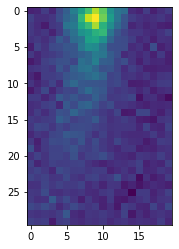

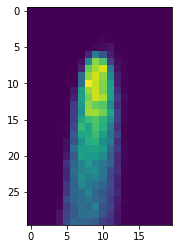

In [84]:
t = 1

p = pred[t, :]
p = p.reshape(30,20)

pr = Y_test[t, :]
pr = pr.reshape(30, 20)

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(p)

plt.figure()
plt.imshow(pr)

In [54]:
from sklearn.svm import SVR

svr = SVR().fit(X_train, Y_train)
pred = svr.predict(X_test)

get_metrics(Y_test, pred)


ValueError: y should be a 1d array, got an array of shape (149, 600) instead.

In [17]:
from sklearn

MLP = MLP.regressor()

/rds/general/user/dk3917/home/ML_test
